# Imports & reading

- new autosklearn fun - must downgrade to swig3, pyrfr >7,<9  
  - https://github.com/automl/auto-sklearn/issues/1025  
  - lesson learned: just use docker  

In [47]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Use this button to hide/reveal raw code."></form>''')


In [33]:
import pandas as pd
import pandas_profiling as pdp
import numpy as np


In [43]:
df_train = pd.read_csv('train.csv')
display("Size of original data set (cols, rows)", df_train.shape)
print('\n\nData Preview')

display(df_train)
display(df_train.dtypes)

'Size of original data set (cols, rows)'

(2666, 18)



Data Preview


last_purchase  max_discount  shoe_spend apparell_spend  acc_spend  \
0              56.5          0.26       322.2          194.3        126   
1              84.0          0.46       279.1          170.9         92   
2              96.0          0.00       294.7            306         96   
3              62.0          0.00       255.4          185.6        100   
4              45.0          0.28       300.6          197.9        154   
...             ...           ...         ...            ...        ...   
2661           83.0          0.29       276.1          193.5         97   
2662           71.0          0.00       154.7          230.1        135   
2663           82.0          0.00       221.9           92.2        113   
2664           79.5          0.42       279.3          158.2        113   
2665           74.0          0.41       201.8          170.8        103   

      custserv_calls  churn  acc_purchasers  promo_purchaser  shoe_orders  \
0                  1      0               0                1            3   
1                  0      0               0                1            2   
2                  1      1               0                0            2   
3                  2      0               0                0            2   
4                  0      0               0                1            3   
...              ...    ...             ...              ...          ...   
2661               2      0               0                1            2   
2662               5      1               0                0            1   
2663               3      0               0                0            2   
2664               0      0               0                1            2   
2665               5      1               1                1            2   

      apparel_orders  acc_orders  gender  ecommShopper  bhShopper state  \
0                  2           4    Male         False       True    MS   
1                  2           3    Male         False      False    OH   
2                  3           3  Female          True      False    MI   
3                  2           3    Male         False      False    VT   
4                  2           5    Male         False       True    WV   
...              ...         ...     ...           ...        ...   ...   
2661               2           3    Male          True       True    ID   
2662               3           4    Male         False      False    OK   
2663               2           4    Male         False       True    MA   
2664               2           4    Male         False       True    VT   
2665               2           3    Male         False       True    VT   

      area_code     phone  
0           510  402-5509  
1           510  370-3021  
2           415  373-1448  
3           510  403-1769  
4           408  405-9384  
...         ...       ...  
2661        510  399-7029  
2662        408  345-1524  
2663        415  419-2767  
2664        415  403-5552  
2665        510  378-3508  

[2666 rows x 18 columns]

last_purchase      float64
max_discount       float64
shoe_spend         float64
apparell_spend      object
acc_spend            int64
custserv_calls       int64
churn                int64
acc_purchasers       int64
promo_purchaser      int64
shoe_orders          int64
apparel_orders       int64
acc_orders           int64
gender              object
ecommShopper          bool
bhShopper             bool
state               object
area_code            int64
phone               object
dtype: object

# EDA
pandas-profiling provides fairly comprehensive data exploration - quickly revealing potential missing data, datatype problems and correlations between IVs 

In [35]:
profile = pdp.ProfileReport(df_train, title='Pandas Profiling Report', explorative=True)
profile.to_file("apparell_data.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/31 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# clean data  
drop phone column due to high cardinality  
clean incorrect dtypes  
fill missing values (since there are very few)  
convert categoricals to 1-hot
separate DV from IVs

In [5]:
# phone isn't useful so we'll drop it
df_train.drop(columns='phone', inplace=True)

In [44]:
# profiling revealed that `apparell_spend` has 1 non-numeric character - we need to drop the row or impute
'''Most occurring categories
Value	Count	Frequency (%)
Decimal Number	10175	81.0%
Other Punctuation	2382	 19.0%
Lowercase Letter	1	 < 0.1%'''

# df_train.apparell_spend[df_train['apparell_spend'].apply(lambda x: x.isnumeric())]
# pd.to_numeric(df_train.apparell_spend, errors='raise')
# ValueError: Unable to parse string "a" at position 707
df_train.apparell_spend = pd.to_numeric(df_train.apparell_spend, errors='coerce')
df_train.apparell_spend[707] = df_train.apparell_spend.mean()
df_train.iloc[[707]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


last_purchase  max_discount  shoe_spend  apparell_spend  acc_spend  \
707           66.0           0.0       314.8      171.388105        116   

     custserv_calls  churn  acc_purchasers  promo_purchaser  shoe_orders  \
707               0      1               0                0            3   

     apparel_orders  acc_orders  gender  ecommShopper  bhShopper state  \
707               2           4  Female         False       True    CA   

     area_code     phone  
707        408  329-9067

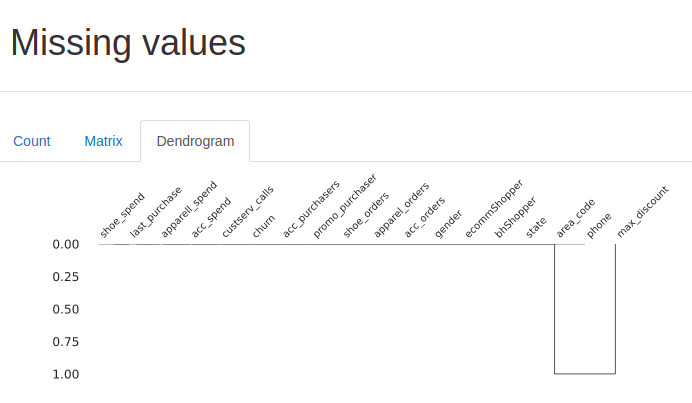

In [7]:
# from profiling - show columns with missing values that need to be resolved
from IPython.display import Image
Image(filename='missing_values.png') 

In [8]:
# impute mode for most common categorical
df_train['area_code'] = df_train['area_code'].fillna(df_train['area_code'].mode())
# impute mean for continuous
df_train['max_discount'] = df_train['max_discount'].fillna(df_train['max_discount'].mean())


In [9]:
# dummies_train = df_train.dropna()
dummies_train = pd.get_dummies(df_train, columns=['gender','ecommShopper','bhShopper',
                                                       'state','area_code'])

In [10]:
# drop or impute? went with impute
# df_train.drop([707],inplace=True)
# df_train.reset_index()
# df_train.apparell_spend = pd.to_numeric(df_train.apparell_spend, errors='raise')
# df_train.dtypes

In [11]:
# ensure that all dtypes are digestible by sklearn
dummies_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_purchase       2666 non-null   float64
 1   max_discount        2666 non-null   float64
 2   shoe_spend          2666 non-null   float64
 3   apparell_spend      2666 non-null   float64
 4   acc_spend           2666 non-null   int64  
 5   custserv_calls      2666 non-null   int64  
 6   churn               2666 non-null   int64  
 7   acc_purchasers      2666 non-null   int64  
 8   promo_purchaser     2666 non-null   int64  
 9   shoe_orders         2666 non-null   int64  
 10  apparel_orders      2666 non-null   int64  
 11  acc_orders          2666 non-null   int64  
 12  gender_Female       2666 non-null   uint8  
 13  gender_Male         2666 non-null   uint8  
 14  ecommShopper_False  2666 non-null   uint8  
 15  ecommShopper_True   2666 non-null   uint8  
 16  bhShop

In [12]:
# separate DV `churn` from IVs 
trainy = np.array(dummies_train['churn'], dtype='int')
dummies_train.drop(columns=['churn'], inplace=True)
trainX=dummies_train.values

# search for best model
auto-sklearn (based on autoML) tests combinations of several model types, preprocessing & hyperparameter search. When compute hours are cheaper than man-hours - this is the place to start.
If a simple model fits, don't bother spending weeks on a neural net.

In [ ]:
import sklearn.metrics
from sklearn.model_selection import train_test_split
import autosklearn.classification

### train model & print best results

In [15]:
X_train, X_test, y_train, y_test = train_test_split(trainX, trainy, test_size=0.25, random_state=42)
cls = autosklearn.classification.AutoSklearnClassifier(metric=autosklearn.metrics.f1, n_jobs=4, memory_limit=6144)
cls.fit(trainX, trainy)
y_hat = cls.predict(X_test)
print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_hat))
print("Balanced Accuracy score", sklearn.metrics.balanced_accuracy_score(y_test, y_hat))

Accuracy score 0.9685157421289355
Balanced Accuracy score 0.9095913801224682


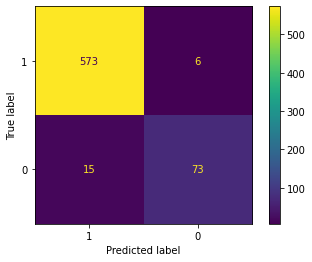

In [23]:
# review confusion matrix to for viz of type I/II errors
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(cm, display_labels=['1','0'])
disp = disp.plot(values_format='.0f')

In [18]:
print(cls.sprint_statistics())

auto-sklearn results:
  Dataset name: 0dd0a830-77d9-11eb-82f2-0242ac110002
  Metric: f1
  Best validation score: 0.748899
  Number of target algorithm runs: 109
  Number of successful target algorithm runs: 98
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 10
  Number of target algorithms that exceeded the memory limit: 1



### list of tested models & params

In [19]:
cls.show_models()

"[(0.260000, SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'random_forest', 'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'none', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:random_forest:bootstrap': 'False', 'classifier:random_forest:criterion': 'entropy', 'classifier:random_forest:max_depth': 'None', 'classifier:random_forest:max_features': 0.9282660347661039, 'classifier:random_forest:max_leaf_nodes': 'None', 'classifier:random_forest:min_impurity_decrease': 0.0, 'classifier:random_forest:min_samples_leaf': 15, 'classifier:random_forest:min_samples_split': 19, 'classifier:random_forest:min_weight_fraction_leaf': 0.0, 'data_preprocessing:cate

### and their results
truncated because the full text is extremely long

In [50]:
str(cls.cv_results_)[:1000]

"{'mean_test_score': array([0.67317073, 0.65346535, 0.        , 0.58358663, 0.29288703,\n       0.        , 0.65822785, 0.31034483, 0.        , 0.        ,\n       0.41628959, 0.58591549, 0.68444444, 0.61403509, 0.6433121 ,\n       0.62650602, 0.69955157, 0.68544601, 0.49342105, 0.5       ,\n       0.51882845, 0.        , 0.64761905, 0.68613139, 0.38190955,\n       0.71615721, 0.69724771, 0.        , 0.464     , 0.72340426,\n       0.46027397, 0.52991453, 0.51737452, 0.52671756, 0.35064935,\n       0.28248588, 0.71372549, 0.7037037 , 0.4516129 , 0.28909953,\n       0.25914936, 0.24203822, 0.63316583, 0.60377358, 0.7027027 ,\n       0.736     , 0.        , 0.68181818, 0.68275862, 0.29106628,\n       0.55457227, 0.66346154, 0.45086705, 0.54347826, 0.33014354,\n       0.39285714, 0.58646617, 0.07194245, 0.34615385, 0.3255814 ,\n       0.68273092, 0.66141732, 0.72881356, 0.44692737, 0.67811159,\n       0.58095238, 0.54375   , 0.29181495, 0.        , 0.70642202,\n       0.        , 0.475862

### Exploration of Profile of Models - sorted by F1

In [22]:
import PipelineProfiler
profiler_data = PipelineProfiler.import_autosklearn(cls)
PipelineProfiler.plot_pipeline_matrix(profiler_data)


In [24]:
predictions = cls.predict(trainX)
predictions

array([0, 0, 1, ..., 0, 0, 1])

In [25]:
print("Accuracy score", sklearn.metrics.accuracy_score(trainy, predictions))
print("Balanced Accuracy score", sklearn.metrics.balanced_accuracy_score(trainy, predictions))

Accuracy score 0.9609902475618904
Balanced Accuracy score 0.8942064821461806


In [30]:
print("Final F1 Score", sklearn.metrics.f1_score(trainy, predictions))

Final F1 Score 0.8594594594594596


# Conclusion & follow on
As usual, random forest is a solid model. The "best" model favors type I errors (FP - incorrectly predicting someone will leave when that person didn't). This is likely the preferred error (within reasonable levels) because a lost customer is likely more expensive than "playing it safe" on advertising to too many potential "defectors"  <br><br>
If I were to spend more time, I would investigate class balancing further since the DV is imbalanced.  
The highly correlated IVs (next couple of cells) should be considered for removal (review source of variance - possibly through PCA - before deciding)

## pearson correlation revealed the following
max_discount is highly correlated with promo_purchaser  
acc_spend is highly correlated with acc_orders  

In [40]:
%%html
{
    "tags": [
        "hide-input",
    ]
}

<div role="tabpanel" class="tab-pane col-sm-12 active" id="correlations_tab-pearson"><div class="correlation-diagram col-sm-12"><!--?xml version="1.0" encoding="utf-8" standalone="no"?--><svg class="img-responsive center-img" height="396pt" version="1.1" viewBox="0 0 576 396" width="576pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink"><metadata><rdf:rdf xmlns:cc="http://creativecommons.org/ns#" xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"><cc:work><dc:type rdf:resource="http://purl.org/dc/dcmitype/StillImage"></dc:type><dc:date>2021-02-26T04:52:12.837361</dc:date><dc:format>image/svg+xml</dc:format><dc:creator><cc:agent><dc:title>Matplotlib v3.3.4, https://matplotlib.org/</dc:title></cc:agent></dc:creator></cc:work></rdf:rdf></metadata><defs><style type="text/css">*{stroke-linecap:butt;stroke-linejoin:round;}</style></defs><g id="figure_1"><g id="patch_1"><path style="fill:#ffffff;" d="M 0 396 
L 576 396 
L 576 0 
L 0 0 
z
"></path></g><g id="axes_1"><g id="patch_2"><path style="fill:#ffffff;" d="M 159.84 316.8 
L 429.12 316.8 
L 429.12 47.52 
L 159.84 47.52 
z
"></path></g><g clip-path="url(#pe04912bdb8)"><image height="270" id="image7872cff753" transform="scale(1 -1)translate(0 -270)" width="270" x="159.84" y="-46.8" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAAAQ4AAAEOCAYAAAB4sfmlAAAG90lEQVR4nO3csYukBx3G8d87M7d7i3HP5BALETFgam0vYqVgIZZWIoh2h6SwEKKdKCiIBLlSK7FInYBoJ8lVVpaKWqQIBi7xNnd7d3uz81rk/oFHnmLBz+cPeNjZeec7U/2WDx+er1OytIae2a778mLHo3Vb2zrZdv9rD54ealsfu7apbS2XF7WtmZl1e1TbWg7F52zt/f+br3Fm5sat27Wt3pMB/N8QDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEBMOILZrjm3atwMPvTNsF0vvDNtJ73Jg3cnuin4XLN2/a7N/XNt6vBzXtnab3kfq+eKpv5mZ+3fv1Lau6FMGXGXCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiO126744V+7Qtncn9OjQe51r8VTrsvbuqn6k9x5U/7biLc6ZmSfF9+B4es/G6cuv1LY+eLt3I3RmZrm8qG35xQHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEBMOICYcQEw4gJhwADHhAGLCAcSEA4jt1uJJt8Nam5qZbtU+9fWf1bbee/PHta0HzcuNM3Nt03sTNtveO9B+No4Pj2tbH//yD2pbZ2+9Vtt6Uv6nbZfe++kXBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEBMOILacn5+Xj7r1LOuht3V5Udtqnlt8/2Kpbc3MPHe0rW1dK36tdF/lzOmt27WtD//8y9rWk8312lbzPOLMzGHX+9v84gBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEBMOICYcQEw4gJhwADHhAGLCAcR2l8XDgbt13xubmRe/9/va1j9+++3aVtO//nNe3XvpZu883FHx3t/py9/vjc3M2d07ta198TPQ/J+t0ztROdM9n+kXBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEBMOICYcQGx59PBB7eLiza/+qDU1MzP3/vTT2ta69BrZvN24Pft3bWtmZv/8Z2pbN27drm2dvf3r2tZM9/1sWtZDbeuqvsYZvziA/4FwADHhAGLCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAserpwPaps8eXtT+t6mSe1rbuvts7Qzgz87Vv/rC2df/undrWg6e9k3ozM8fb3rO2rr3nbLdZalttj/a998AvDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEBMOICYcQGw3a++c2O7s3drWzMzfL16obX32xnFt652Htanqqb+ZmT+8/vPa1u6Dd2pbf3tys7Y1M/O5T/Tez6Nt79zf8aZ47rJ8ivO5a709vziAmHAAMeEAYsIBxIQDiAkHEBMOICYcQEw4gJhwADHhAGLCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiy/n5ee1I4nJ50Zp6Nng1u3b6pVdqW39581e1rZmZl06rczXr9qi6txz2xbHec7YWt3qXUD/y6LJ3D/VqfjKBK004gJhwADHhAGLCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiA2K45drnpnofbFG+n3bh1u7Z19tZrta37+267HxUPzl3fto/X9TRPB37yG7+obb33xqu1rYvux3NOlsvall8cQEw4gJhwADHhAGLCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiA2HJ+fr7WxlpDz5wWz/3dv3unttU8W/fXe09rWzMzn3/hem3rZFN7NObF7/6utjUz88/ffKu2tS6978/qZ+Dyork2U3ydfnEAMeEAYsIBxIQDiAkHEBMOICYcQEw4gJhwADHhAGLCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiu+aps+apv5mZs+K5v8veFbzZrofa1heP3q9tzczst5+ubd38yqu1rXt//Elta6Z77u/QfDam92ys26Pa1kz3dfrFAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQEw4gJhxATDiAmHAAMeEAYsIBxIQDiAkHEFuufeE7tUuEzRuhMzPFE4lX1nLYlwev5nfBvvwdtW0eyy1qvp/7ZVfbaruaTxlwpQkHEBMOICYcQEw4gJhwADHhAGLCAcSEA4gJBxATDiAmHEBMOICYcAAx4QBiwgHEhAOICQcQ+y8lyvAw82dHDgAAAABJRU5ErkJggg=="></image></g><g id="matplotlib.axis_1"><g id="xtick_1"><g id="text_1"><g style="fill:#262626;" transform="translate(172.077455 396.234375)rotate(-90)scale(0.1 -0.1)"><defs><path id="DejaVuSans-108" d="M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 0 
L 9.421875 0 
z
"></path><path id="DejaVuSans-97" d="M 34.28125 27.484375 
Q 23.390625 27.484375 19.1875 25 
Q 14.984375 22.515625 14.984375 16.5 
Q 14.984375 11.71875 18.140625 8.90625 
Q 21.296875 6.109375 26.703125 6.109375 
Q 34.1875 6.109375 38.703125 11.40625 
Q 43.21875 16.703125 43.21875 25.484375 
L 43.21875 27.484375 
z
M 52.203125 31.203125 
L 52.203125 0 
L 43.21875 0 
L 43.21875 8.296875 
Q 40.140625 3.328125 35.546875 0.953125 
Q 30.953125 -1.421875 24.3125 -1.421875 
Q 15.921875 -1.421875 10.953125 3.296875 
Q 6 8.015625 6 15.921875 
Q 6 25.140625 12.171875 29.828125 
Q 18.359375 34.515625 30.609375 34.515625 
L 43.21875 34.515625 
L 43.21875 35.40625 
Q 43.21875 41.609375 39.140625 45 
Q 35.0625 48.390625 27.6875 48.390625 
Q 23 48.390625 18.546875 47.265625 
Q 14.109375 46.140625 10.015625 43.890625 
L 10.015625 52.203125 
Q 14.9375 54.109375 19.578125 55.046875 
Q 24.21875 56 28.609375 56 
Q 40.484375 56 46.34375 49.84375 
Q 52.203125 43.703125 52.203125 31.203125 
z
"></path><path id="DejaVuSans-115" d="M 44.28125 53.078125 
L 44.28125 44.578125 
Q 40.484375 46.53125 36.375 47.5 
Q 32.28125 48.484375 27.875 48.484375 
Q 21.1875 48.484375 17.84375 46.4375 
Q 14.5 44.390625 14.5 40.28125 
Q 14.5 37.15625 16.890625 35.375 
Q 19.28125 33.59375 26.515625 31.984375 
L 29.59375 31.296875 
Q 39.15625 29.25 43.1875 25.515625 
Q 47.21875 21.78125 47.21875 15.09375 
Q 47.21875 7.46875 41.1875 3.015625 
Q 35.15625 -1.421875 24.609375 -1.421875 
Q 20.21875 -1.421875 15.453125 -0.5625 
Q 10.6875 0.296875 5.421875 2 
L 5.421875 11.28125 
Q 10.40625 8.6875 15.234375 7.390625 
Q 20.0625 6.109375 24.8125 6.109375 
Q 31.15625 6.109375 34.5625 8.28125 
Q 37.984375 10.453125 37.984375 14.40625 
Q 37.984375 18.0625 35.515625 20.015625 
Q 33.0625 21.96875 24.703125 23.78125 
L 21.578125 24.515625 
Q 13.234375 26.265625 9.515625 29.90625 
Q 5.8125 33.546875 5.8125 39.890625 
Q 5.8125 47.609375 11.28125 51.796875 
Q 16.75 56 26.8125 56 
Q 31.78125 56 36.171875 55.265625 
Q 40.578125 54.546875 44.28125 53.078125 
z
"></path><path id="DejaVuSans-116" d="M 18.3125 70.21875 
L 18.3125 54.6875 
L 36.8125 54.6875 
L 36.8125 47.703125 
L 18.3125 47.703125 
L 18.3125 18.015625 
Q 18.3125 11.328125 20.140625 9.421875 
Q 21.96875 7.515625 27.59375 7.515625 
L 36.8125 7.515625 
L 36.8125 0 
L 27.59375 0 
Q 17.1875 0 13.234375 3.875 
Q 9.28125 7.765625 9.28125 18.015625 
L 9.28125 47.703125 
L 2.6875 47.703125 
L 2.6875 54.6875 
L 9.28125 54.6875 
L 9.28125 70.21875 
z
"></path><path id="DejaVuSans-95" d="M 50.984375 -16.609375 
L 50.984375 -23.578125 
L -0.984375 -23.578125 
L -0.984375 -16.609375 
z
"></path><path id="DejaVuSans-112" d="M 18.109375 8.203125 
L 18.109375 -20.796875 
L 9.078125 -20.796875 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
z
M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
"></path><path id="DejaVuSans-117" d="M 8.5 21.578125 
L 8.5 54.6875 
L 17.484375 54.6875 
L 17.484375 21.921875 
Q 17.484375 14.15625 20.5 10.265625 
Q 23.53125 6.390625 29.59375 6.390625 
Q 36.859375 6.390625 41.078125 11.03125 
Q 45.3125 15.671875 45.3125 23.6875 
L 45.3125 54.6875 
L 54.296875 54.6875 
L 54.296875 0 
L 45.3125 0 
L 45.3125 8.40625 
Q 42.046875 3.421875 37.71875 1 
Q 33.40625 -1.421875 27.6875 -1.421875 
Q 18.265625 -1.421875 13.375 4.4375 
Q 8.5 10.296875 8.5 21.578125 
z
M 31.109375 56 
z
"></path><path id="DejaVuSans-114" d="M 41.109375 46.296875 
Q 39.59375 47.171875 37.8125 47.578125 
Q 36.03125 48 33.890625 48 
Q 26.265625 48 22.1875 43.046875 
Q 18.109375 38.09375 18.109375 28.8125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 20.953125 51.171875 25.484375 53.578125 
Q 30.03125 56 36.53125 56 
Q 37.453125 56 38.578125 55.875 
Q 39.703125 55.765625 41.0625 55.515625 
z
"></path><path id="DejaVuSans-99" d="M 48.78125 52.59375 
L 48.78125 44.1875 
Q 44.96875 46.296875 41.140625 47.34375 
Q 37.3125 48.390625 33.40625 48.390625 
Q 24.65625 48.390625 19.8125 42.84375 
Q 14.984375 37.3125 14.984375 27.296875 
Q 14.984375 17.28125 19.8125 11.734375 
Q 24.65625 6.203125 33.40625 6.203125 
Q 37.3125 6.203125 41.140625 7.25 
Q 44.96875 8.296875 48.78125 10.40625 
L 48.78125 2.09375 
Q 45.015625 0.34375 40.984375 -0.53125 
Q 36.96875 -1.421875 32.421875 -1.421875 
Q 20.0625 -1.421875 12.78125 6.34375 
Q 5.515625 14.109375 5.515625 27.296875 
Q 5.515625 40.671875 12.859375 48.328125 
Q 20.21875 56 33.015625 56 
Q 37.15625 56 41.109375 55.140625 
Q 45.0625 54.296875 48.78125 52.59375 
z
"></path><path id="DejaVuSans-104" d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 75.984375 
L 18.109375 75.984375 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
"></path><path id="DejaVuSans-101" d="M 56.203125 29.59375 
L 56.203125 25.203125 
L 14.890625 25.203125 
Q 15.484375 15.921875 20.484375 11.0625 
Q 25.484375 6.203125 34.421875 6.203125 
Q 39.59375 6.203125 44.453125 7.46875 
Q 49.3125 8.734375 54.109375 11.28125 
L 54.109375 2.78125 
Q 49.265625 0.734375 44.1875 -0.34375 
Q 39.109375 -1.421875 33.890625 -1.421875 
Q 20.796875 -1.421875 13.15625 6.1875 
Q 5.515625 13.8125 5.515625 26.8125 
Q 5.515625 40.234375 12.765625 48.109375 
Q 20.015625 56 32.328125 56 
Q 43.359375 56 49.78125 48.890625 
Q 56.203125 41.796875 56.203125 29.59375 
z
M 47.21875 32.234375 
Q 47.125 39.59375 43.09375 43.984375 
Q 39.0625 48.390625 32.421875 48.390625 
Q 24.90625 48.390625 20.390625 44.140625 
Q 15.875 39.890625 15.1875 32.171875 
z
"></path></defs><use xlink:href="#DejaVuSans-108"></use><use x="27.783203" xlink:href="#DejaVuSans-97"></use><use x="89.0625" xlink:href="#DejaVuSans-115"></use><use x="141.162109" xlink:href="#DejaVuSans-116"></use><use x="180.371094" xlink:href="#DejaVuSans-95"></use><use x="230.371094" xlink:href="#DejaVuSans-112"></use><use x="293.847656" xlink:href="#DejaVuSans-117"></use><use x="357.226562" xlink:href="#DejaVuSans-114"></use><use x="396.089844" xlink:href="#DejaVuSans-99"></use><use x="451.070312" xlink:href="#DejaVuSans-104"></use><use x="514.449219" xlink:href="#DejaVuSans-97"></use><use x="575.728516" xlink:href="#DejaVuSans-115"></use><use x="627.828125" xlink:href="#DejaVuSans-101"></use></g></g></g><g id="xtick_2"><g id="text_2"><g style="fill:#262626;" transform="translate(191.311741 396.635937)rotate(-90)scale(0.1 -0.1)"><defs><path id="DejaVuSans-109" d="M 52 44.1875 
Q 55.375 50.25 60.0625 53.125 
Q 64.75 56 71.09375 56 
Q 79.640625 56 84.28125 50.015625 
Q 88.921875 44.046875 88.921875 33.015625 
L 88.921875 0 
L 79.890625 0 
L 79.890625 32.71875 
Q 79.890625 40.578125 77.09375 44.375 
Q 74.3125 48.1875 68.609375 48.1875 
Q 61.625 48.1875 57.5625 43.546875 
Q 53.515625 38.921875 53.515625 30.90625 
L 53.515625 0 
L 44.484375 0 
L 44.484375 32.71875 
Q 44.484375 40.625 41.703125 44.40625 
Q 38.921875 48.1875 33.109375 48.1875 
Q 26.21875 48.1875 22.15625 43.53125 
Q 18.109375 38.875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.1875 51.21875 25.484375 53.609375 
Q 29.78125 56 35.6875 56 
Q 41.65625 56 45.828125 52.96875 
Q 50 49.953125 52 44.1875 
z
"></path><path id="DejaVuSans-120" d="M 54.890625 54.6875 
L 35.109375 28.078125 
L 55.90625 0 
L 45.3125 0 
L 29.390625 21.484375 
L 13.484375 0 
L 2.875 0 
L 24.125 28.609375 
L 4.6875 54.6875 
L 15.28125 54.6875 
L 29.78125 35.203125 
L 44.28125 54.6875 
z
"></path><path id="DejaVuSans-100" d="M 45.40625 46.390625 
L 45.40625 75.984375 
L 54.390625 75.984375 
L 54.390625 0 
L 45.40625 0 
L 45.40625 8.203125 
Q 42.578125 3.328125 38.25 0.953125 
Q 33.9375 -1.421875 27.875 -1.421875 
Q 17.96875 -1.421875 11.734375 6.484375 
Q 5.515625 14.40625 5.515625 27.296875 
Q 5.515625 40.1875 11.734375 48.09375 
Q 17.96875 56 27.875 56 
Q 33.9375 56 38.25 53.625 
Q 42.578125 51.265625 45.40625 46.390625 
z
M 14.796875 27.296875 
Q 14.796875 17.390625 18.875 11.75 
Q 22.953125 6.109375 30.078125 6.109375 
Q 37.203125 6.109375 41.296875 11.75 
Q 45.40625 17.390625 45.40625 27.296875 
Q 45.40625 37.203125 41.296875 42.84375 
Q 37.203125 48.484375 30.078125 48.484375 
Q 22.953125 48.484375 18.875 42.84375 
Q 14.796875 37.203125 14.796875 27.296875 
z
"></path><path id="DejaVuSans-105" d="M 9.421875 54.6875 
L 18.40625 54.6875 
L 18.40625 0 
L 9.421875 0 
z
M 9.421875 75.984375 
L 18.40625 75.984375 
L 18.40625 64.59375 
L 9.421875 64.59375 
z
"></path><path id="DejaVuSans-111" d="M 30.609375 48.390625 
Q 23.390625 48.390625 19.1875 42.75 
Q 14.984375 37.109375 14.984375 27.296875 
Q 14.984375 17.484375 19.15625 11.84375 
Q 23.34375 6.203125 30.609375 6.203125 
Q 37.796875 6.203125 41.984375 11.859375 
Q 46.1875 17.53125 46.1875 27.296875 
Q 46.1875 37.015625 41.984375 42.703125 
Q 37.796875 48.390625 30.609375 48.390625 
z
M 30.609375 56 
Q 42.328125 56 49.015625 48.375 
Q 55.71875 40.765625 55.71875 27.296875 
Q 55.71875 13.875 49.015625 6.21875 
Q 42.328125 -1.421875 30.609375 -1.421875 
Q 18.84375 -1.421875 12.171875 6.21875 
Q 5.515625 13.875 5.515625 27.296875 
Q 5.515625 40.765625 12.171875 48.375 
Q 18.84375 56 30.609375 56 
z
"></path><path id="DejaVuSans-110" d="M 54.890625 33.015625 
L 54.890625 0 
L 45.90625 0 
L 45.90625 32.71875 
Q 45.90625 40.484375 42.875 44.328125 
Q 39.84375 48.1875 33.796875 48.1875 
Q 26.515625 48.1875 22.3125 43.546875 
Q 18.109375 38.921875 18.109375 30.90625 
L 18.109375 0 
L 9.078125 0 
L 9.078125 54.6875 
L 18.109375 54.6875 
L 18.109375 46.1875 
Q 21.34375 51.125 25.703125 53.5625 
Q 30.078125 56 35.796875 56 
Q 45.21875 56 50.046875 50.171875 
Q 54.890625 44.34375 54.890625 33.015625 
z
"></path></defs><use xlink:href="#DejaVuSans-109"></use><use x="97.412109" xlink:href="#DejaVuSans-97"></use><use x="158.691406" xlink:href="#DejaVuSans-120"></use><use x="217.871094" xlink:href="#DejaVuSans-95"></use><use x="267.871094" xlink:href="#DejaVuSans-100"></use><use x="331.347656" xlink:href="#DejaVuSans-105"></use><use x="359.130859" xlink:href="#DejaVuSans-115"></use><use x="411.230469" xlink:href="#DejaVuSans-99"></use><use x="466.210938" xlink:href="#DejaVuSans-111"></use><use x="527.392578" xlink:href="#DejaVuSans-117"></use><use x="590.771484" xlink:href="#DejaVuSans-110"></use><use x="654.150391" xlink:href="#DejaVuSans-116"></use></g></g></g><g id="xtick_3"><g id="text_3"><g style="fill:#262626;" transform="translate(210.546027 386.515625)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-115"></use><use x="52.099609" xlink:href="#DejaVuSans-104"></use><use x="115.478516" xlink:href="#DejaVuSans-111"></use><use x="176.660156" xlink:href="#DejaVuSans-101"></use><use x="238.183594" xlink:href="#DejaVuSans-95"></use><use x="288.183594" xlink:href="#DejaVuSans-115"></use><use x="340.283203" xlink:href="#DejaVuSans-112"></use><use x="403.759766" xlink:href="#DejaVuSans-101"></use><use x="465.283203" xlink:href="#DejaVuSans-110"></use><use x="528.662109" xlink:href="#DejaVuSans-100"></use></g></g></g><g id="xtick_4"><g id="text_4"><g style="fill:#262626;" transform="translate(229.780313 379.821875)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-99"></use><use x="116.259766" xlink:href="#DejaVuSans-99"></use><use x="171.240234" xlink:href="#DejaVuSans-95"></use><use x="221.240234" xlink:href="#DejaVuSans-115"></use><use x="273.339844" xlink:href="#DejaVuSans-112"></use><use x="336.816406" xlink:href="#DejaVuSans-101"></use><use x="398.339844" xlink:href="#DejaVuSans-110"></use><use x="461.71875" xlink:href="#DejaVuSans-100"></use></g></g></g><g id="xtick_5"><g id="text_5"><g style="fill:#262626;" transform="translate(249.014598 397.05)rotate(-90)scale(0.1 -0.1)"><defs><path id="DejaVuSans-118" d="M 2.984375 54.6875 
L 12.5 54.6875 
L 29.59375 8.796875 
L 46.6875 54.6875 
L 56.203125 54.6875 
L 35.6875 0 
L 23.484375 0 
z
"></path></defs><use xlink:href="#DejaVuSans-99"></use><use x="54.980469" xlink:href="#DejaVuSans-117"></use><use x="118.359375" xlink:href="#DejaVuSans-115"></use><use x="170.458984" xlink:href="#DejaVuSans-116"></use><use x="209.667969" xlink:href="#DejaVuSans-115"></use><use x="261.767578" xlink:href="#DejaVuSans-101"></use><use x="323.291016" xlink:href="#DejaVuSans-114"></use><use x="364.404297" xlink:href="#DejaVuSans-118"></use><use x="423.583984" xlink:href="#DejaVuSans-95"></use><use x="473.583984" xlink:href="#DejaVuSans-99"></use><use x="528.564453" xlink:href="#DejaVuSans-97"></use><use x="589.84375" xlink:href="#DejaVuSans-108"></use><use x="617.626953" xlink:href="#DejaVuSans-108"></use><use x="645.410156" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="xtick_6"><g id="text_6"><g style="fill:#262626;" transform="translate(268.387946 355.746875)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-99"></use><use x="54.980469" xlink:href="#DejaVuSans-104"></use><use x="118.359375" xlink:href="#DejaVuSans-117"></use><use x="181.738281" xlink:href="#DejaVuSans-114"></use><use x="221.101562" xlink:href="#DejaVuSans-110"></use></g></g></g><g id="xtick_7"><g id="text_7"><g style="fill:#262626;" transform="translate(287.48317 404.64375)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-99"></use><use x="116.259766" xlink:href="#DejaVuSans-99"></use><use x="171.240234" xlink:href="#DejaVuSans-95"></use><use x="221.240234" xlink:href="#DejaVuSans-112"></use><use x="284.716797" xlink:href="#DejaVuSans-117"></use><use x="348.095703" xlink:href="#DejaVuSans-114"></use><use x="386.958984" xlink:href="#DejaVuSans-99"></use><use x="441.939453" xlink:href="#DejaVuSans-104"></use><use x="505.318359" xlink:href="#DejaVuSans-97"></use><use x="566.597656" xlink:href="#DejaVuSans-115"></use><use x="618.697266" xlink:href="#DejaVuSans-101"></use><use x="680.220703" xlink:href="#DejaVuSans-114"></use><use x="721.333984" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="xtick_8"><g id="text_8"><g style="fill:#262626;" transform="translate(306.717455 414.521875)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-112"></use><use x="63.476562" xlink:href="#DejaVuSans-114"></use><use x="102.339844" xlink:href="#DejaVuSans-111"></use><use x="163.521484" xlink:href="#DejaVuSans-109"></use><use x="260.933594" xlink:href="#DejaVuSans-111"></use><use x="322.115234" xlink:href="#DejaVuSans-95"></use><use x="372.115234" xlink:href="#DejaVuSans-112"></use><use x="435.591797" xlink:href="#DejaVuSans-117"></use><use x="498.970703" xlink:href="#DejaVuSans-114"></use><use x="537.833984" xlink:href="#DejaVuSans-99"></use><use x="592.814453" xlink:href="#DejaVuSans-104"></use><use x="656.193359" xlink:href="#DejaVuSans-97"></use><use x="717.472656" xlink:href="#DejaVuSans-115"></use><use x="769.572266" xlink:href="#DejaVuSans-101"></use><use x="831.095703" xlink:href="#DejaVuSans-114"></use></g></g></g><g id="xtick_9"><g id="text_9"><g style="fill:#262626;" transform="translate(325.951741 387.995312)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-115"></use><use x="52.099609" xlink:href="#DejaVuSans-104"></use><use x="115.478516" xlink:href="#DejaVuSans-111"></use><use x="176.660156" xlink:href="#DejaVuSans-101"></use><use x="238.183594" xlink:href="#DejaVuSans-95"></use><use x="288.183594" xlink:href="#DejaVuSans-111"></use><use x="349.365234" xlink:href="#DejaVuSans-114"></use><use x="388.728516" xlink:href="#DejaVuSans-100"></use><use x="452.205078" xlink:href="#DejaVuSans-101"></use><use x="513.728516" xlink:href="#DejaVuSans-114"></use><use x="554.841797" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="xtick_10"><g id="text_10"><g style="fill:#262626;" transform="translate(345.186027 401.946875)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-112"></use><use x="124.755859" xlink:href="#DejaVuSans-112"></use><use x="188.232422" xlink:href="#DejaVuSans-97"></use><use x="249.511719" xlink:href="#DejaVuSans-114"></use><use x="288.375" xlink:href="#DejaVuSans-101"></use><use x="349.898438" xlink:href="#DejaVuSans-108"></use><use x="377.681641" xlink:href="#DejaVuSans-95"></use><use x="427.681641" xlink:href="#DejaVuSans-111"></use><use x="488.863281" xlink:href="#DejaVuSans-114"></use><use x="528.226562" xlink:href="#DejaVuSans-100"></use><use x="591.703125" xlink:href="#DejaVuSans-101"></use><use x="653.226562" xlink:href="#DejaVuSans-114"></use><use x="694.339844" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="xtick_11"><g id="text_11"><g style="fill:#262626;" transform="translate(364.420313 381.301562)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-99"></use><use x="116.259766" xlink:href="#DejaVuSans-99"></use><use x="171.240234" xlink:href="#DejaVuSans-95"></use><use x="221.240234" xlink:href="#DejaVuSans-111"></use><use x="282.421875" xlink:href="#DejaVuSans-114"></use><use x="321.785156" xlink:href="#DejaVuSans-100"></use><use x="385.261719" xlink:href="#DejaVuSans-101"></use><use x="446.785156" xlink:href="#DejaVuSans-114"></use><use x="487.898438" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="xtick_12"><g id="text_12"><g style="fill:#262626;" transform="translate(383.793661 406.317187)rotate(-90)scale(0.1 -0.1)"><defs><path id="DejaVuSans-83" d="M 53.515625 70.515625 
L 53.515625 60.890625 
Q 47.90625 63.578125 42.921875 64.890625 
Q 37.9375 66.21875 33.296875 66.21875 
Q 25.25 66.21875 20.875 63.09375 
Q 16.5 59.96875 16.5 54.203125 
Q 16.5 49.359375 19.40625 46.890625 
Q 22.3125 44.4375 30.421875 42.921875 
L 36.375 41.703125 
Q 47.40625 39.59375 52.65625 34.296875 
Q 57.90625 29 57.90625 20.125 
Q 57.90625 9.515625 50.796875 4.046875 
Q 43.703125 -1.421875 29.984375 -1.421875 
Q 24.8125 -1.421875 18.96875 -0.25 
Q 13.140625 0.921875 6.890625 3.21875 
L 6.890625 13.375 
Q 12.890625 10.015625 18.65625 8.296875 
Q 24.421875 6.59375 29.984375 6.59375 
Q 38.421875 6.59375 43.015625 9.90625 
Q 47.609375 13.234375 47.609375 19.390625 
Q 47.609375 24.75 44.3125 27.78125 
Q 41.015625 30.8125 33.5 32.328125 
L 27.484375 33.5 
Q 16.453125 35.6875 11.515625 40.375 
Q 6.59375 45.0625 6.59375 53.421875 
Q 6.59375 63.09375 13.40625 68.65625 
Q 20.21875 74.21875 32.171875 74.21875 
Q 37.3125 74.21875 42.625 73.28125 
Q 47.953125 72.359375 53.515625 70.515625 
z
"></path></defs><use xlink:href="#DejaVuSans-101"></use><use x="61.523438" xlink:href="#DejaVuSans-99"></use><use x="116.503906" xlink:href="#DejaVuSans-111"></use><use x="177.685547" xlink:href="#DejaVuSans-109"></use><use x="275.097656" xlink:href="#DejaVuSans-109"></use><use x="372.509766" xlink:href="#DejaVuSans-83"></use><use x="435.986328" xlink:href="#DejaVuSans-104"></use><use x="499.365234" xlink:href="#DejaVuSans-111"></use><use x="560.546875" xlink:href="#DejaVuSans-112"></use><use x="624.023438" xlink:href="#DejaVuSans-112"></use><use x="687.5" xlink:href="#DejaVuSans-101"></use><use x="749.023438" xlink:href="#DejaVuSans-114"></use></g></g></g><g id="xtick_13"><g id="text_13"><g style="fill:#262626;" transform="translate(403.027946 381.751562)rotate(-90)scale(0.1 -0.1)"><defs><path id="DejaVuSans-98" d="M 48.6875 27.296875 
Q 48.6875 37.203125 44.609375 42.84375 
Q 40.53125 48.484375 33.40625 48.484375 
Q 26.265625 48.484375 22.1875 42.84375 
Q 18.109375 37.203125 18.109375 27.296875 
Q 18.109375 17.390625 22.1875 11.75 
Q 26.265625 6.109375 33.40625 6.109375 
Q 40.53125 6.109375 44.609375 11.75 
Q 48.6875 17.390625 48.6875 27.296875 
z
M 18.109375 46.390625 
Q 20.953125 51.265625 25.265625 53.625 
Q 29.59375 56 35.59375 56 
Q 45.5625 56 51.78125 48.09375 
Q 58.015625 40.1875 58.015625 27.296875 
Q 58.015625 14.40625 51.78125 6.484375 
Q 45.5625 -1.421875 35.59375 -1.421875 
Q 29.59375 -1.421875 25.265625 0.953125 
Q 20.953125 3.328125 18.109375 8.203125 
L 18.109375 0 
L 9.078125 0 
L 9.078125 75.984375 
L 18.109375 75.984375 
z
"></path></defs><use xlink:href="#DejaVuSans-98"></use><use x="63.476562" xlink:href="#DejaVuSans-104"></use><use x="126.855469" xlink:href="#DejaVuSans-83"></use><use x="190.332031" xlink:href="#DejaVuSans-104"></use><use x="253.710938" xlink:href="#DejaVuSans-111"></use><use x="314.892578" xlink:href="#DejaVuSans-112"></use><use x="378.369141" xlink:href="#DejaVuSans-112"></use><use x="441.845703" xlink:href="#DejaVuSans-101"></use><use x="503.369141" xlink:href="#DejaVuSans-114"></use></g></g></g><g id="xtick_14"><g id="text_14"><g style="fill:#262626;" transform="translate(422.12317 378.714062)rotate(-90)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-114"></use><use x="100.142578" xlink:href="#DejaVuSans-101"></use><use x="161.666016" xlink:href="#DejaVuSans-97"></use><use x="222.945312" xlink:href="#DejaVuSans-95"></use><use x="272.945312" xlink:href="#DejaVuSans-99"></use><use x="327.925781" xlink:href="#DejaVuSans-111"></use><use x="389.107422" xlink:href="#DejaVuSans-100"></use><use x="452.583984" xlink:href="#DejaVuSans-101"></use></g></g></g></g><g id="matplotlib.axis_2"><g id="ytick_1"><g id="text_15"><g style="fill:#262626;" transform="translate(80.405625 60.936362)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-108"></use><use x="27.783203" xlink:href="#DejaVuSans-97"></use><use x="89.0625" xlink:href="#DejaVuSans-115"></use><use x="141.162109" xlink:href="#DejaVuSans-116"></use><use x="180.371094" xlink:href="#DejaVuSans-95"></use><use x="230.371094" xlink:href="#DejaVuSans-112"></use><use x="293.847656" xlink:href="#DejaVuSans-117"></use><use x="357.226562" xlink:href="#DejaVuSans-114"></use><use x="396.089844" xlink:href="#DejaVuSans-99"></use><use x="451.070312" xlink:href="#DejaVuSans-104"></use><use x="514.449219" xlink:href="#DejaVuSans-97"></use><use x="575.728516" xlink:href="#DejaVuSans-115"></use><use x="627.828125" xlink:href="#DejaVuSans-101"></use></g></g></g><g id="ytick_2"><g id="text_16"><g style="fill:#262626;" transform="translate(80.004063 80.170647)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-109"></use><use x="97.412109" xlink:href="#DejaVuSans-97"></use><use x="158.691406" xlink:href="#DejaVuSans-120"></use><use x="217.871094" xlink:href="#DejaVuSans-95"></use><use x="267.871094" xlink:href="#DejaVuSans-100"></use><use x="331.347656" xlink:href="#DejaVuSans-105"></use><use x="359.130859" xlink:href="#DejaVuSans-115"></use><use x="411.230469" xlink:href="#DejaVuSans-99"></use><use x="466.210938" xlink:href="#DejaVuSans-111"></use><use x="527.392578" xlink:href="#DejaVuSans-117"></use><use x="590.771484" xlink:href="#DejaVuSans-110"></use><use x="654.150391" xlink:href="#DejaVuSans-116"></use></g></g></g><g id="ytick_3"><g id="text_17"><g style="fill:#262626;" transform="translate(90.124375 99.404933)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-115"></use><use x="52.099609" xlink:href="#DejaVuSans-104"></use><use x="115.478516" xlink:href="#DejaVuSans-111"></use><use x="176.660156" xlink:href="#DejaVuSans-101"></use><use x="238.183594" xlink:href="#DejaVuSans-95"></use><use x="288.183594" xlink:href="#DejaVuSans-115"></use><use x="340.283203" xlink:href="#DejaVuSans-112"></use><use x="403.759766" xlink:href="#DejaVuSans-101"></use><use x="465.283203" xlink:href="#DejaVuSans-110"></use><use x="528.662109" xlink:href="#DejaVuSans-100"></use></g></g></g><g id="ytick_4"><g id="text_18"><g style="fill:#262626;" transform="translate(96.818125 118.639219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-99"></use><use x="116.259766" xlink:href="#DejaVuSans-99"></use><use x="171.240234" xlink:href="#DejaVuSans-95"></use><use x="221.240234" xlink:href="#DejaVuSans-115"></use><use x="273.339844" xlink:href="#DejaVuSans-112"></use><use x="336.816406" xlink:href="#DejaVuSans-101"></use><use x="398.339844" xlink:href="#DejaVuSans-110"></use><use x="461.71875" xlink:href="#DejaVuSans-100"></use></g></g></g><g id="ytick_5"><g id="text_19"><g style="fill:#262626;" transform="translate(79.59 137.873504)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-99"></use><use x="54.980469" xlink:href="#DejaVuSans-117"></use><use x="118.359375" xlink:href="#DejaVuSans-115"></use><use x="170.458984" xlink:href="#DejaVuSans-116"></use><use x="209.667969" xlink:href="#DejaVuSans-115"></use><use x="261.767578" xlink:href="#DejaVuSans-101"></use><use x="323.291016" xlink:href="#DejaVuSans-114"></use><use x="364.404297" xlink:href="#DejaVuSans-118"></use><use x="423.583984" xlink:href="#DejaVuSans-95"></use><use x="473.583984" xlink:href="#DejaVuSans-99"></use><use x="528.564453" xlink:href="#DejaVuSans-97"></use><use x="589.84375" xlink:href="#DejaVuSans-108"></use><use x="617.626953" xlink:href="#DejaVuSans-108"></use><use x="645.410156" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="ytick_6"><g id="text_20"><g style="fill:#262626;" transform="translate(120.893125 157.10779)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-99"></use><use x="54.980469" xlink:href="#DejaVuSans-104"></use><use x="118.359375" xlink:href="#DejaVuSans-117"></use><use x="181.738281" xlink:href="#DejaVuSans-114"></use><use x="221.101562" xlink:href="#DejaVuSans-110"></use></g></g></g><g id="ytick_7"><g id="text_21"><g style="fill:#262626;" transform="translate(71.99625 176.342076)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-99"></use><use x="116.259766" xlink:href="#DejaVuSans-99"></use><use x="171.240234" xlink:href="#DejaVuSans-95"></use><use x="221.240234" xlink:href="#DejaVuSans-112"></use><use x="284.716797" xlink:href="#DejaVuSans-117"></use><use x="348.095703" xlink:href="#DejaVuSans-114"></use><use x="386.958984" xlink:href="#DejaVuSans-99"></use><use x="441.939453" xlink:href="#DejaVuSans-104"></use><use x="505.318359" xlink:href="#DejaVuSans-97"></use><use x="566.597656" xlink:href="#DejaVuSans-115"></use><use x="618.697266" xlink:href="#DejaVuSans-101"></use><use x="680.220703" xlink:href="#DejaVuSans-114"></use><use x="721.333984" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="ytick_8"><g id="text_22"><g style="fill:#262626;" transform="translate(62.118125 195.576362)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-112"></use><use x="63.476562" xlink:href="#DejaVuSans-114"></use><use x="102.339844" xlink:href="#DejaVuSans-111"></use><use x="163.521484" xlink:href="#DejaVuSans-109"></use><use x="260.933594" xlink:href="#DejaVuSans-111"></use><use x="322.115234" xlink:href="#DejaVuSans-95"></use><use x="372.115234" xlink:href="#DejaVuSans-112"></use><use x="435.591797" xlink:href="#DejaVuSans-117"></use><use x="498.970703" xlink:href="#DejaVuSans-114"></use><use x="537.833984" xlink:href="#DejaVuSans-99"></use><use x="592.814453" xlink:href="#DejaVuSans-104"></use><use x="656.193359" xlink:href="#DejaVuSans-97"></use><use x="717.472656" xlink:href="#DejaVuSans-115"></use><use x="769.572266" xlink:href="#DejaVuSans-101"></use><use x="831.095703" xlink:href="#DejaVuSans-114"></use></g></g></g><g id="ytick_9"><g id="text_23"><g style="fill:#262626;" transform="translate(88.644688 214.810647)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-115"></use><use x="52.099609" xlink:href="#DejaVuSans-104"></use><use x="115.478516" xlink:href="#DejaVuSans-111"></use><use x="176.660156" xlink:href="#DejaVuSans-101"></use><use x="238.183594" xlink:href="#DejaVuSans-95"></use><use x="288.183594" xlink:href="#DejaVuSans-111"></use><use x="349.365234" xlink:href="#DejaVuSans-114"></use><use x="388.728516" xlink:href="#DejaVuSans-100"></use><use x="452.205078" xlink:href="#DejaVuSans-101"></use><use x="513.728516" xlink:href="#DejaVuSans-114"></use><use x="554.841797" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="ytick_10"><g id="text_24"><g style="fill:#262626;" transform="translate(74.693125 234.044933)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-112"></use><use x="124.755859" xlink:href="#DejaVuSans-112"></use><use x="188.232422" xlink:href="#DejaVuSans-97"></use><use x="249.511719" xlink:href="#DejaVuSans-114"></use><use x="288.375" xlink:href="#DejaVuSans-101"></use><use x="349.898438" xlink:href="#DejaVuSans-108"></use><use x="377.681641" xlink:href="#DejaVuSans-95"></use><use x="427.681641" xlink:href="#DejaVuSans-111"></use><use x="488.863281" xlink:href="#DejaVuSans-114"></use><use x="528.226562" xlink:href="#DejaVuSans-100"></use><use x="591.703125" xlink:href="#DejaVuSans-101"></use><use x="653.226562" xlink:href="#DejaVuSans-114"></use><use x="694.339844" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="ytick_11"><g id="text_25"><g style="fill:#262626;" transform="translate(95.338438 253.279219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-99"></use><use x="116.259766" xlink:href="#DejaVuSans-99"></use><use x="171.240234" xlink:href="#DejaVuSans-95"></use><use x="221.240234" xlink:href="#DejaVuSans-111"></use><use x="282.421875" xlink:href="#DejaVuSans-114"></use><use x="321.785156" xlink:href="#DejaVuSans-100"></use><use x="385.261719" xlink:href="#DejaVuSans-101"></use><use x="446.785156" xlink:href="#DejaVuSans-114"></use><use x="487.898438" xlink:href="#DejaVuSans-115"></use></g></g></g><g id="ytick_12"><g id="text_26"><g style="fill:#262626;" transform="translate(70.322813 272.513504)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-101"></use><use x="61.523438" xlink:href="#DejaVuSans-99"></use><use x="116.503906" xlink:href="#DejaVuSans-111"></use><use x="177.685547" xlink:href="#DejaVuSans-109"></use><use x="275.097656" xlink:href="#DejaVuSans-109"></use><use x="372.509766" xlink:href="#DejaVuSans-83"></use><use x="435.986328" xlink:href="#DejaVuSans-104"></use><use x="499.365234" xlink:href="#DejaVuSans-111"></use><use x="560.546875" xlink:href="#DejaVuSans-112"></use><use x="624.023438" xlink:href="#DejaVuSans-112"></use><use x="687.5" xlink:href="#DejaVuSans-101"></use><use x="749.023438" xlink:href="#DejaVuSans-114"></use></g></g></g><g id="ytick_13"><g id="text_27"><g style="fill:#262626;" transform="translate(94.888438 291.74779)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-98"></use><use x="63.476562" xlink:href="#DejaVuSans-104"></use><use x="126.855469" xlink:href="#DejaVuSans-83"></use><use x="190.332031" xlink:href="#DejaVuSans-104"></use><use x="253.710938" xlink:href="#DejaVuSans-111"></use><use x="314.892578" xlink:href="#DejaVuSans-112"></use><use x="378.369141" xlink:href="#DejaVuSans-112"></use><use x="441.845703" xlink:href="#DejaVuSans-101"></use><use x="503.369141" xlink:href="#DejaVuSans-114"></use></g></g></g><g id="ytick_14"><g id="text_28"><g style="fill:#262626;" transform="translate(97.925938 310.982076)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-97"></use><use x="61.279297" xlink:href="#DejaVuSans-114"></use><use x="100.142578" xlink:href="#DejaVuSans-101"></use><use x="161.666016" xlink:href="#DejaVuSans-97"></use><use x="222.945312" xlink:href="#DejaVuSans-95"></use><use x="272.945312" xlink:href="#DejaVuSans-99"></use><use x="327.925781" xlink:href="#DejaVuSans-111"></use><use x="389.107422" xlink:href="#DejaVuSans-100"></use><use x="452.583984" xlink:href="#DejaVuSans-101"></use></g></g></g></g><g id="patch_3"><path style="fill:none;" d="M 159.84 316.8 
L 159.84 47.52 
"></path></g><g id="patch_4"><path style="fill:none;" d="M 429.12 316.8 
L 429.12 47.52 
"></path></g><g id="patch_5"><path style="fill:none;" d="M 159.84 316.8 
L 429.12 316.8 
"></path></g><g id="patch_6"><path style="fill:none;" d="M 159.84 47.52 
L 429.12 47.52 
"></path></g></g><g id="axes_2"><g id="patch_7"><path clip-path="url(#p0452e40d98)" style="fill:#ffffff;stroke:#ffffff;stroke-linejoin:miter;stroke-width:0.01;" d="M 451.44 316.8 
L 451.44 315.748125 
L 451.44 48.571875 
L 451.44 47.52 
L 464.904 47.52 
L 464.904 48.571875 
L 464.904 315.748125 
L 464.904 316.8 
z
"></path></g><g id="matplotlib.axis_3"></g><g id="matplotlib.axis_4"><g id="ytick_15"><g id="line2d_1"><defs><path id="m78fef271e3" style="stroke:#262626;" d="M 0 0 
L 3.5 0 
"></path></defs><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="316.8"></use></g></g><g id="text_29"><g style="fill:#262626;" transform="translate(475.404 320.599219)scale(0.1 -0.1)"><defs><path id="DejaVuSans-8722" d="M 10.59375 35.5 
L 73.1875 35.5 
L 73.1875 27.203125 
L 10.59375 27.203125 
z
"></path><path id="DejaVuSans-49" d="M 12.40625 8.296875 
L 28.515625 8.296875 
L 28.515625 63.921875 
L 10.984375 60.40625 
L 10.984375 69.390625 
L 28.421875 72.90625 
L 38.28125 72.90625 
L 38.28125 8.296875 
L 54.390625 8.296875 
L 54.390625 0 
L 12.40625 0 
z
"></path><path id="DejaVuSans-46" d="M 10.6875 12.40625 
L 21 12.40625 
L 21 0 
L 10.6875 0 
z
"></path><path id="DejaVuSans-48" d="M 31.78125 66.40625 
Q 24.171875 66.40625 20.328125 58.90625 
Q 16.5 51.421875 16.5 36.375 
Q 16.5 21.390625 20.328125 13.890625 
Q 24.171875 6.390625 31.78125 6.390625 
Q 39.453125 6.390625 43.28125 13.890625 
Q 47.125 21.390625 47.125 36.375 
Q 47.125 51.421875 43.28125 58.90625 
Q 39.453125 66.40625 31.78125 66.40625 
z
M 31.78125 74.21875 
Q 44.046875 74.21875 50.515625 64.515625 
Q 56.984375 54.828125 56.984375 36.375 
Q 56.984375 17.96875 50.515625 8.265625 
Q 44.046875 -1.421875 31.78125 -1.421875 
Q 19.53125 -1.421875 13.0625 8.265625 
Q 6.59375 17.96875 6.59375 36.375 
Q 6.59375 54.828125 13.0625 64.515625 
Q 19.53125 74.21875 31.78125 74.21875 
z
"></path></defs><use xlink:href="#DejaVuSans-8722"></use><use x="83.789062" xlink:href="#DejaVuSans-49"></use><use x="147.412109" xlink:href="#DejaVuSans-46"></use><use x="179.199219" xlink:href="#DejaVuSans-48"></use><use x="242.822266" xlink:href="#DejaVuSans-48"></use></g></g></g><g id="ytick_16"><g id="line2d_2"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="283.14"></use></g></g><g id="text_30"><g style="fill:#262626;" transform="translate(475.404 286.939219)scale(0.1 -0.1)"><defs><path id="DejaVuSans-55" d="M 8.203125 72.90625 
L 55.078125 72.90625 
L 55.078125 68.703125 
L 28.609375 0 
L 18.3125 0 
L 43.21875 64.59375 
L 8.203125 64.59375 
z
"></path><path id="DejaVuSans-53" d="M 10.796875 72.90625 
L 49.515625 72.90625 
L 49.515625 64.59375 
L 19.828125 64.59375 
L 19.828125 46.734375 
Q 21.96875 47.46875 24.109375 47.828125 
Q 26.265625 48.1875 28.421875 48.1875 
Q 40.625 48.1875 47.75 41.5 
Q 54.890625 34.8125 54.890625 23.390625 
Q 54.890625 11.625 47.5625 5.09375 
Q 40.234375 -1.421875 26.90625 -1.421875 
Q 22.3125 -1.421875 17.546875 -0.640625 
Q 12.796875 0.140625 7.71875 1.703125 
L 7.71875 11.625 
Q 12.109375 9.234375 16.796875 8.0625 
Q 21.484375 6.890625 26.703125 6.890625 
Q 35.15625 6.890625 40.078125 11.328125 
Q 45.015625 15.765625 45.015625 23.390625 
Q 45.015625 31 40.078125 35.4375 
Q 35.15625 39.890625 26.703125 39.890625 
Q 22.75 39.890625 18.8125 39.015625 
Q 14.890625 38.140625 10.796875 36.28125 
z
"></path></defs><use xlink:href="#DejaVuSans-8722"></use><use x="83.789062" xlink:href="#DejaVuSans-48"></use><use x="147.412109" xlink:href="#DejaVuSans-46"></use><use x="179.199219" xlink:href="#DejaVuSans-55"></use><use x="242.822266" xlink:href="#DejaVuSans-53"></use></g></g></g><g id="ytick_17"><g id="line2d_3"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="249.48"></use></g></g><g id="text_31"><g style="fill:#262626;" transform="translate(475.404 253.279219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-8722"></use><use x="83.789062" xlink:href="#DejaVuSans-48"></use><use x="147.412109" xlink:href="#DejaVuSans-46"></use><use x="179.199219" xlink:href="#DejaVuSans-53"></use><use x="242.822266" xlink:href="#DejaVuSans-48"></use></g></g></g><g id="ytick_18"><g id="line2d_4"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="215.82"></use></g></g><g id="text_32"><g style="fill:#262626;" transform="translate(475.404 219.619219)scale(0.1 -0.1)"><defs><path id="DejaVuSans-50" d="M 19.1875 8.296875 
L 53.609375 8.296875 
L 53.609375 0 
L 7.328125 0 
L 7.328125 8.296875 
Q 12.9375 14.109375 22.625 23.890625 
Q 32.328125 33.6875 34.8125 36.53125 
Q 39.546875 41.84375 41.421875 45.53125 
Q 43.3125 49.21875 43.3125 52.78125 
Q 43.3125 58.59375 39.234375 62.25 
Q 35.15625 65.921875 28.609375 65.921875 
Q 23.96875 65.921875 18.8125 64.3125 
Q 13.671875 62.703125 7.8125 59.421875 
L 7.8125 69.390625 
Q 13.765625 71.78125 18.9375 73 
Q 24.125 74.21875 28.421875 74.21875 
Q 39.75 74.21875 46.484375 68.546875 
Q 53.21875 62.890625 53.21875 53.421875 
Q 53.21875 48.921875 51.53125 44.890625 
Q 49.859375 40.875 45.40625 35.40625 
Q 44.1875 33.984375 37.640625 27.21875 
Q 31.109375 20.453125 19.1875 8.296875 
z
"></path></defs><use xlink:href="#DejaVuSans-8722"></use><use x="83.789062" xlink:href="#DejaVuSans-48"></use><use x="147.412109" xlink:href="#DejaVuSans-46"></use><use x="179.199219" xlink:href="#DejaVuSans-50"></use><use x="242.822266" xlink:href="#DejaVuSans-53"></use></g></g></g><g id="ytick_19"><g id="line2d_5"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="182.16"></use></g></g><g id="text_33"><g style="fill:#262626;" transform="translate(475.404 185.959219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-48"></use><use x="63.623047" xlink:href="#DejaVuSans-46"></use><use x="95.410156" xlink:href="#DejaVuSans-48"></use><use x="159.033203" xlink:href="#DejaVuSans-48"></use></g></g></g><g id="ytick_20"><g id="line2d_6"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="148.5"></use></g></g><g id="text_34"><g style="fill:#262626;" transform="translate(475.404 152.299219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-48"></use><use x="63.623047" xlink:href="#DejaVuSans-46"></use><use x="95.410156" xlink:href="#DejaVuSans-50"></use><use x="159.033203" xlink:href="#DejaVuSans-53"></use></g></g></g><g id="ytick_21"><g id="line2d_7"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="114.84"></use></g></g><g id="text_35"><g style="fill:#262626;" transform="translate(475.404 118.639219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-48"></use><use x="63.623047" xlink:href="#DejaVuSans-46"></use><use x="95.410156" xlink:href="#DejaVuSans-53"></use><use x="159.033203" xlink:href="#DejaVuSans-48"></use></g></g></g><g id="ytick_22"><g id="line2d_8"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="81.18"></use></g></g><g id="text_36"><g style="fill:#262626;" transform="translate(475.404 84.979219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-48"></use><use x="63.623047" xlink:href="#DejaVuSans-46"></use><use x="95.410156" xlink:href="#DejaVuSans-55"></use><use x="159.033203" xlink:href="#DejaVuSans-53"></use></g></g></g><g id="ytick_23"><g id="line2d_9"><g><use style="fill:#262626;stroke:#262626;" x="464.904" xlink:href="#m78fef271e3" y="47.52"></use></g></g><g id="text_37"><g style="fill:#262626;" transform="translate(475.404 51.319219)scale(0.1 -0.1)"><use xlink:href="#DejaVuSans-49"></use><use x="63.623047" xlink:href="#DejaVuSans-46"></use><use x="95.410156" xlink:href="#DejaVuSans-48"></use><use x="159.033203" xlink:href="#DejaVuSans-48"></use></g></g></g></g><image height="269" id="imaged52a0f1614" transform="scale(1 -1)translate(0 -269)" width="14" x="451" y="-48" xlink:href="data:image/png;base64,
iVBORw0KGgoAAAANSUhEUgAAAA4AAAENCAYAAAA/q1TLAAABhElEQVR4nO2ZSxLDIAxDzecePV7vv29Cb5DF02BGge7fyLKFQ9Lyjc8I8OutECyit8LIozhFsTJBK48+inQaa5qDwdfP0UmxUrDAWnulYGnsgKwotcJSheYwkO8cPA6hq3iO2ckRIpcectrVBQFIXx17ZJUqwi3Hd47QnHSQPgJKaxSkIeelGnU1G+RZ9fEo3HOyQ05B4YK0wRxLhXMMDmbvVaFUGnLq8ZT6AAoBSPao7Jz0Y3U2wARwwbEqVJGCI10x6McuHLkVHrPvOVsEIN8j3gA2kTsBmKQIPQ70Z3BEvyHZoaCwrG7qcVCPXJFxSzwyQSlyWNHIY/KxUrpKFYN6zE4O3zlWzYGKFzwegiJfyDt4RFz0C5KKR8RJc3TxqNxzqEfanAVzPB4fQOzxgFuDfOf8bDxucqzYfWVBqU7J8QEHvudgRfzGmr6suEf6FsC/PKQHgCcnOwBeIUfcCcAckHZV+RDk4rGP+7IBL59SfcDbp9QNAiDsHPoW4BS59wcAg385ime8vkq1wwAAAABJRU5ErkJggg=="></image><g id="patch_8"><path style="fill:none;" d="M 451.44 316.8 
L 451.44 315.748125 
L 451.44 48.571875 
L 451.44 47.52 
L 464.904 47.52 
L 464.904 48.571875 
L 464.904 315.748125 
L 464.904 316.8 
z
"></path></g></g></g><defs><clipPath id="pe04912bdb8"><rect height="269.28" width="269.28" x="159.84" y="47.52"></rect></clipPath><clipPath id="p0452e40d98"><rect height="269.28" width="13.464" x="451.44" y="47.52"></rect></clipPath></defs></svg></div><div class="col-sm-6 correlation-description" style="display: none;"><div style="padding:20px" class="text-muted"><h3>Pearson's r</h3>The Pearson's correlation coefficient (<em>r</em>) is a measure of linear correlation between two variables. It's value lies between -1 and +1, -1 indicating total negative linear correlation, 0 indicating no linear correlation and 1 indicating total positive linear correlation. Furthermore, <em>r</em> is invariant under separate changes in location and scale of the two variables, implying that for a linear function the angle to the x-axis does not affect <em>r</em>.<br><br>To calculate <em>r</em> for two variables <em>X</em> and <em>Y</em>, one divides the covariance of <em>X</em> and <em>Y</em> by the product of their standard deviations. </div></div></div>